In [1]:
1

1

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy.external as sce
from sklearn import preprocessing
import pickle5 as pickle
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
import sklearn
from sklearn.neighbors import KNeighborsClassifier

from utils import *

eps=1e-100


/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import torch.nn as nn
class NNTransfer(nn.Module):
    def __init__(self, input_dim=128, output_dim=10):
        super(NNTransfer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)
        self.activate = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x= self.activate(x)
        return x

def NNTransferTrain(model, criterion, optimizer, train_loader,val_loader, device, save_dir,label_key,focus_name, epochs=200):
    eval_accuracy_mini=0#np.inf
    patience_count=0
    for epoch in range(epochs):
        model.train()
        loss_all=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_all+=loss.item()
        eval_loss, eval_accuracy = NNTransferEvaluate(model, val_loader, criterion, device)
        if eval_accuracy_mini<eval_accuracy:
            eval_accuracy_mini=eval_accuracy
#             torch.save(model.state_dict(), pth+f"/predictor/FuseMap_NNtransfer_transfer_tissue_region_sub_refine.pt")
            print(f"Epoch {epoch}/{epochs} - Train Loss: {loss_all / len(train_loader)}, Accuracy: {eval_accuracy}")
            patience_count=0
        else:
            patience_count+=1
        if patience_count>10:
            p=0
            print(f"Epoch {epoch}/{epochs} - early stopping due to patience count")
            break

def NNTransferEvaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    return total_loss/len(dataloader), accuracy

def NNTransferPredictWithUncertainty(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_uncertainties = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs[0].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            confidence = torch.max(outputs, dim=1)[0]
            uncertainty = 1 - confidence
            all_predictions.extend(predicted.detach().cpu().numpy())
            all_uncertainties.extend(uncertainty.detach().cpu().numpy())

    return np.vstack(all_predictions), np.vstack(all_uncertainties)


In [4]:
tissueregion_all_o=sc.read_h5ad(f"source_data/transfer_tissueregion_ref.h5ad")    


/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### transfer main tissue region

In [5]:
ad_embed_OB = tissueregion_all_o[tissueregion_all_o.obs['name']=='ref']

ad_embed_train = ad_embed_OB
sample1_embeddings = ad_embed_train.X
sample1_labels = list(ad_embed_train.obs['gt_tissue_region_main'])

le = preprocessing.LabelEncoder()
le.fit(sample1_labels)


sample1_labels = le.transform(sample1_labels)
sample1_labels = sample1_labels.astype('str').astype('int')


dataset1 = TensorDataset(torch.Tensor(sample1_embeddings), torch.Tensor(sample1_labels).long())
train_size = int(0.90 * len(dataset1))  # Use 80% of the data for training
val_size = len(dataset1) - train_size
train_dataset, val_dataset = random_split(dataset1, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weight = torch.Tensor(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',
                                                                            classes=np.unique(sample1_labels),
                                                                            y=sample1_labels))
model = NNTransfer(input_dim=sample1_embeddings.shape[1],
                   output_dim=len(np.unique(sample1_labels)))
model.to(device)  # Move the model to GPU if available
criterion = nn.CrossEntropyLoss(weight=class_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

NNTransferTrain(model, criterion, optimizer, train_loader, val_loader, device, 0, 0, 0)


sample2_embeddings = tissueregion_all_o.X#[celltype_all_o.obs['name']!='ref'].X
dataset2 = TensorDataset(torch.Tensor(sample2_embeddings))
dataloader2 = DataLoader(dataset2, batch_size=256, shuffle=False)
sample2_predictions,sample2_uncertainty = NNTransferPredictWithUncertainty(model, dataloader2, device)
sample2_predictions = le.inverse_transform(sample2_predictions)

# celltype_all_o.obs.loc[celltype_all_o.obs['name']!='ref',f'transfer_query_cell_type_main_STARmap'] = sample2_predictions
tissueregion_all_o.obs[f'transfer_gt_tissue_region_main_ref'] = sample2_predictions


Epoch 0/200 - Train Loss: 1.8544917135011583, Accuracy: 85.44520547945206
Epoch 1/200 - Train Loss: 1.5578109565235319, Accuracy: 88.18493150684931
Epoch 2/200 - Train Loss: 1.3933626186280024, Accuracy: 89.12671232876713
Epoch 3/200 - Train Loss: 1.341095702988761, Accuracy: 91.52397260273973
Epoch 8/200 - Train Loss: 1.2534968938146318, Accuracy: 91.86643835616438
Epoch 10/200 - Train Loss: 1.2429514215106057, Accuracy: 92.03767123287672
Epoch 11/200 - Train Loss: 1.2463871893428622, Accuracy: 92.72260273972603
Epoch 22/200 - early stopping due to patience count


/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Spatial embedding colored by data source')

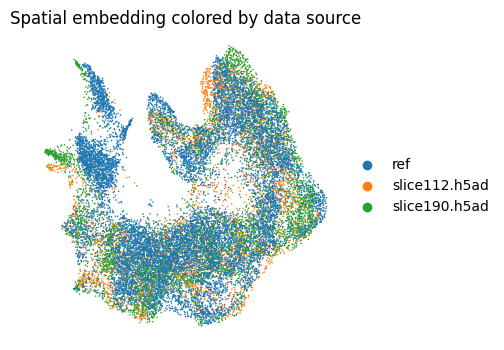

In [6]:
fig,ax = plt.subplots(figsize=(4,4))
ax = sc.pl.umap(tissueregion_all_o,color='name',size=5,
                ax=ax,show=False)
plt.axis('off')
plt.title('Spatial embedding colored by data source')

In [7]:
for i in tissueregion_all_o.obs['batch'].unique():
    sub = tissueregion_all_o[tissueregion_all_o.obs['batch']==i]
    label = sub.obs['transfer_gt_tissue_region_main_ref']
    location = np.array(sub.obs[['x','y']])
    knn = KNeighborsClassifier(n_neighbors=30)
    knn.fit(location, label)

    predicted_labels = knn.predict(location)
    tissueregion_all_o.obs.loc[tissueregion_all_o.obs['batch']==i,'transfer_gt_tissue_region_main_ref'] = predicted_labels


/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Text(0.5, 1.0, 'Spatial embedding, colored by transferred main level tissue regions')

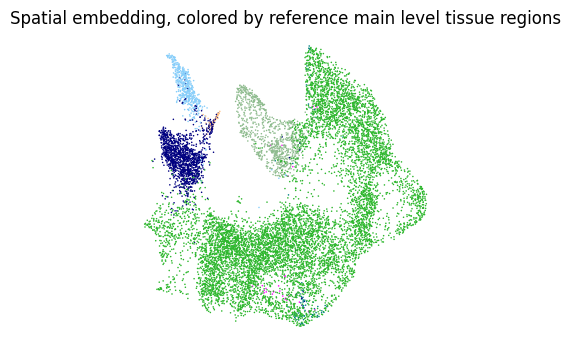

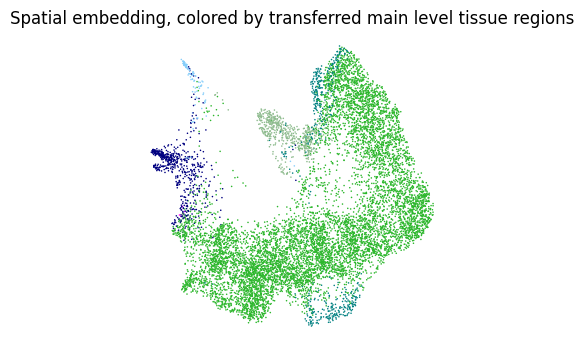

In [8]:
### main cell type color
color_dic_main=pd.read_csv('source_data/color/tissue_domain/starmap_main.csv',
                           index_col=0)
color_dic=dict(zip(color_dic_main['key'],color_dic_main['color']))


fig,ax = plt.subplots(figsize=(4,4))
ax = sc.pl.umap(tissueregion_all_o[tissueregion_all_o.obs['name']=='ref',:],
                color='gt_tissue_region_main',size=5,
                palette=color_dic,legend_loc=[],ax=ax,show=False)
plt.axis('off')
plt.title('Spatial embedding, colored by reference main level tissue regions')


fig,ax = plt.subplots(figsize=(4,4))
ax = sc.pl.umap(tissueregion_all_o[tissueregion_all_o.obs['name']!='ref',:],
                color='transfer_gt_tissue_region_main_ref',size=5,
                palette=color_dic,legend_loc=[],ax=ax,show=False)
plt.axis('off')
plt.title('Spatial embedding, colored by transferred main level tissue regions')


Text(0.5, 1.0, 'Spatial map, colored by reference main level tissue regions')

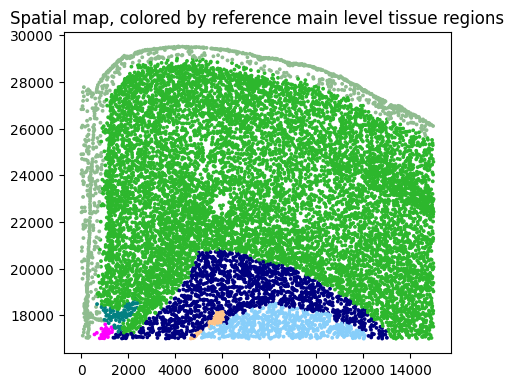

In [9]:
focus=tissueregion_all_o[tissueregion_all_o.obs['name']=='ref']
coeefi=(max(focus.obs['x'])-min(focus.obs['x']))/(max(focus.obs['y'])-min(focus.obs['y']))

plt.figure(figsize=(5,5*coeefi))
plt.scatter(focus.obs['y'],
           focus.obs['x'],
            s=3,
           c=[color_dic[i] for i in focus.obs['gt_tissue_region_main']])
plt.title('Spatial map, colored by reference main level tissue regions')


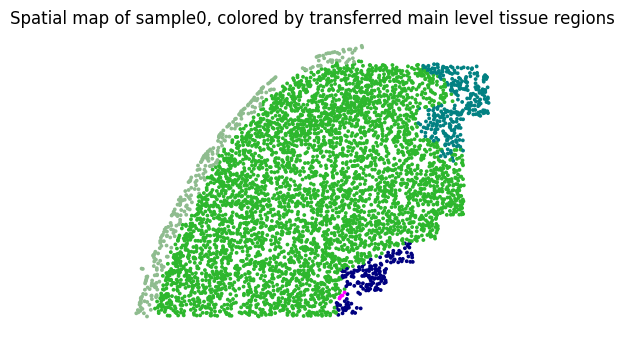

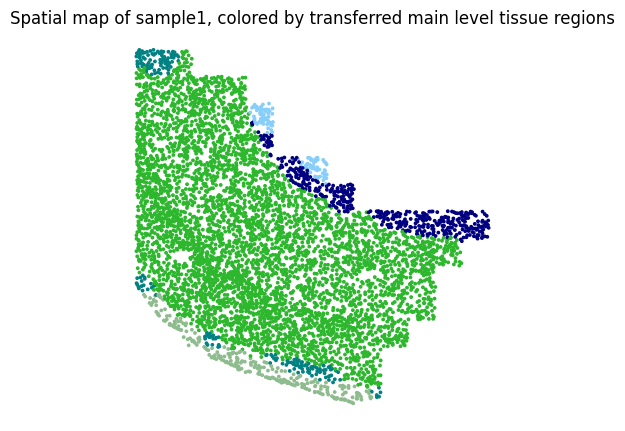

In [10]:
for batch_key in ['sample0','sample1']:
    focus=tissueregion_all_o[tissueregion_all_o.obs['batch']==batch_key]
    coeefi=(max(focus.obs['x'])-min(focus.obs['x']))/(max(focus.obs['y'])-min(focus.obs['y']))

    plt.figure(figsize=(5,5*coeefi))
    plt.scatter(focus.obs['y'],
               focus.obs['x'],
                s=3,
               c=[color_dic[i] for i in focus.obs['transfer_gt_tissue_region_main_ref']])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.title(f'Spatial map of {batch_key}, colored by transferred main level tissue regions')


### transfer sub tissue region

In [11]:
result_celltype=tissueregion_all_o
gt_ref_key='gt_tissue_region_main'
gt_ref_sub_key='gt_tissue_region_sub'
transfer_key='transfer_gt_tissue_region_main_ref'
result_celltype.obs[f'transfer_{gt_ref_sub_key}']='-1'

In [12]:
for focus_main in result_celltype[result_celltype.obs['name']=='ref'].obs[gt_ref_key].unique():
    print(focus_main)
    
    ad_embed_OB = result_celltype[result_celltype.obs[transfer_key]==focus_main]
    if ad_embed_OB.shape[0]==0:
        continue
    sub_list=list(result_celltype[result_celltype.obs[gt_ref_key]==focus_main].obs[gt_ref_sub_key].value_counts().keys())

    ad_embed_train = result_celltype[result_celltype.obs[gt_ref_sub_key].isin(sub_list)]
    sample1_embeddings = ad_embed_train.X
    sample1_labels = list(ad_embed_train.obs[gt_ref_sub_key])
        
    le = preprocessing.LabelEncoder()
    le.fit(sample1_labels)
    
    
    sample1_labels = le.transform(sample1_labels)
    sample1_labels = sample1_labels.astype('str').astype('int')
    

    dataset1 = TensorDataset(torch.Tensor(sample1_embeddings), torch.Tensor(sample1_labels).long())
    train_size = int(0.95 * len(dataset1))  # Use 80% of the data for training
    val_size = len(dataset1) - train_size
    train_dataset, val_dataset = random_split(dataset1, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    
    import torch.optim as optim
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_weight = torch.Tensor(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',
                                                                                classes=np.unique(sample1_labels),
                                                                                y=sample1_labels))
    model = NNTransfer(input_dim=sample1_embeddings.shape[1],
                       output_dim=len(np.unique(sample1_labels)))
    model.to(device)  # Move the model to GPU if available
    criterion = nn.CrossEntropyLoss(weight=class_weight.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    NNTransferTrain(model, criterion, optimizer, train_loader, val_loader, device, 0, 0, 0)

    
    sample2_embeddings = ad_embed_OB.X
    dataset2 = TensorDataset(torch.Tensor(sample2_embeddings))
    dataloader2 = DataLoader(dataset2, batch_size=256, shuffle=False)
    sample2_predictions,sample2_uncertainty = NNTransferPredictWithUncertainty(model, dataloader2, device)
    sample2_predictions = le.inverse_transform(sample2_predictions)

    result_celltype.obs.loc[result_celltype.obs[transfer_key]==focus_main,f'transfer_{gt_ref_sub_key}'] = sample2_predictions
    result_celltype.obs.loc[result_celltype.obs[transfer_key]==focus_main,f'transfer_{gt_ref_sub_key}_uncertainty'] = sample2_uncertainty
    
    # ad_embed.obs[f'transfer_{label_key}_{focus_name}_uncertainty'] = sample2_uncertainty


HPF_CA
Epoch 0/200 - Train Loss: 1.0998493432998657, Accuracy: 50.0
Epoch 1/200 - Train Loss: 1.0951251983642578, Accuracy: 100.0
Epoch 12/200 - early stopping due to patience count
L1_HPFmo_Mngs
Epoch 0/200 - Train Loss: 1.3805350959300995, Accuracy: 77.27272727272727
Epoch 1/200 - Train Loss: 1.3578062951564789, Accuracy: 79.54545454545455
Epoch 2/200 - Train Loss: 1.3403795659542084, Accuracy: 84.0909090909091
Epoch 8/200 - Train Loss: 1.1952740848064423, Accuracy: 88.63636363636364


/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 19/200 - early stopping due to patience count
CTX_2
Epoch 0/200 - Train Loss: 1.607629656791687, Accuracy: 40.0
Epoch 3/200 - Train Loss: 1.5968533754348755, Accuracy: 60.0
Epoch 14/200 - early stopping due to patience count
FbTrt
Epoch 0/200 - Train Loss: 0.6733991702397665, Accuracy: 88.73239436619718
Epoch 1/200 - Train Loss: 0.6319866875807444, Accuracy: 92.95774647887323
Epoch 2/200 - Train Loss: 0.5890608330567678, Accuracy: 94.36619718309859
Epoch 13/200 - early stopping due to patience count
CTX_1
Epoch 0/200 - Train Loss: 2.618089401360714, Accuracy: 27.816091954022987
Epoch 1/200 - Train Loss: 2.5021398067474365, Accuracy: 34.94252873563219
Epoch 2/200 - Train Loss: 2.3545664512749873, Accuracy: 47.35632183908046
Epoch 3/200 - Train Loss: 2.239040887717045, Accuracy: 67.816091954023
Epoch 4/200 - Train Loss: 2.1766191973830713, Accuracy: 70.34482758620689
Epoch 5/200 - Train Loss: 2.142168630253185, Accuracy: 74.25287356321839
Epoch 7/200 - Train Loss: 2.109199480576948

In [13]:
ad_embed=result_celltype
ad_embed.obs['transfer_gt_tissue_region_sub_O'] = ad_embed.obs['transfer_gt_tissue_region_sub'].copy()

for i in ad_embed.obs['batch'].unique():
    sub = ad_embed[ad_embed.obs['batch']==i]
    label = sub.obs['transfer_gt_tissue_region_sub']
    location = np.array(sub.obs[['x','y']])
    knn = KNeighborsClassifier(n_neighbors=30)
    knn.fit(location, label)

    predicted_labels = knn.predict(location)
    ad_embed.obs.loc[ad_embed.obs['batch']==i,'transfer_gt_tissue_region_sub'] = predicted_labels


/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jialiulab/.conda/envs/fusemap_glue/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificatio

Text(0.5, 1.0, 'Spatial embedding, colored by transferred sublevel tissue regions')

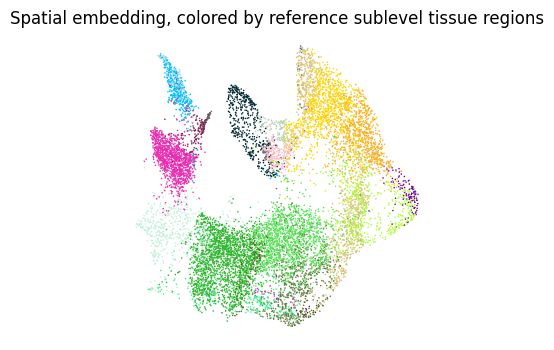

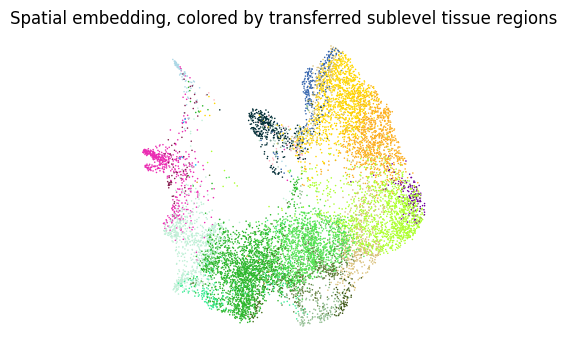

In [14]:
color_dic_main=pd.read_csv('source_data/color/tissue_domain/starmap_sub_old.csv',
                           index_col=0)
color_dic=dict(zip(color_dic_main['key'],color_dic_main['color']))

fig,ax = plt.subplots(figsize=(4,4))
ax = sc.pl.umap(ad_embed[ad_embed.obs['name']=='ref',:],color='gt_tissue_region_sub',size=5,
                palette=color_dic,legend_loc=[],ax=ax,show=False)
plt.axis('off')
plt.title('Spatial embedding, colored by reference sublevel tissue regions')


fig,ax = plt.subplots(figsize=(4,4))
ax = sc.pl.umap(ad_embed[ad_embed.obs['name']!='ref',:],color='transfer_gt_tissue_region_sub',size=5,
                palette=color_dic,legend_loc=[],ax=ax,show=False)
plt.axis('off')
plt.title('Spatial embedding, colored by transferred sublevel tissue regions')


Text(0.5, 1.0, 'Spatial map, colored by reference sublevel tissue regions')

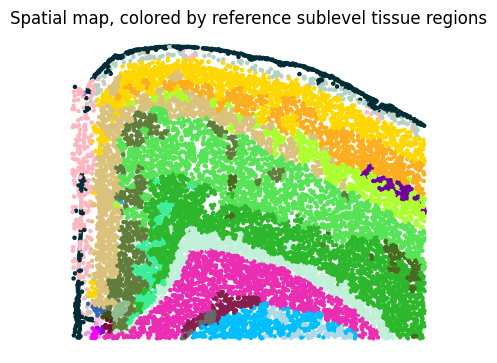

In [15]:
focus=tissueregion_all_o[tissueregion_all_o.obs['name']=='ref']
coeefi=(max(focus.obs['x'])-min(focus.obs['x']))/(max(focus.obs['y'])-min(focus.obs['y']))

plt.figure(figsize=(5,5*coeefi))
plt.scatter(focus.obs['y'],
           focus.obs['x'],
            s=5,
           c=[color_dic[i] for i in focus.obs['gt_tissue_region_sub']])
# plt.gca().invert_yaxis()
plt.axis('off')
plt.title('Spatial map, colored by reference sublevel tissue regions')


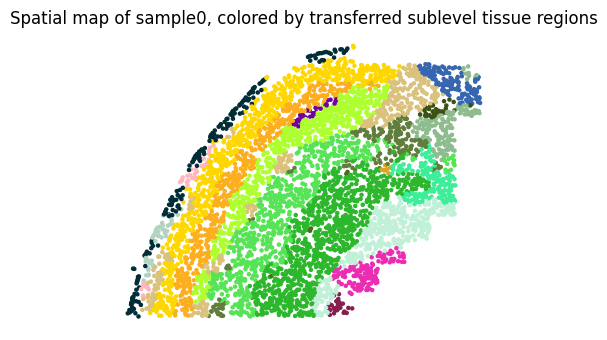

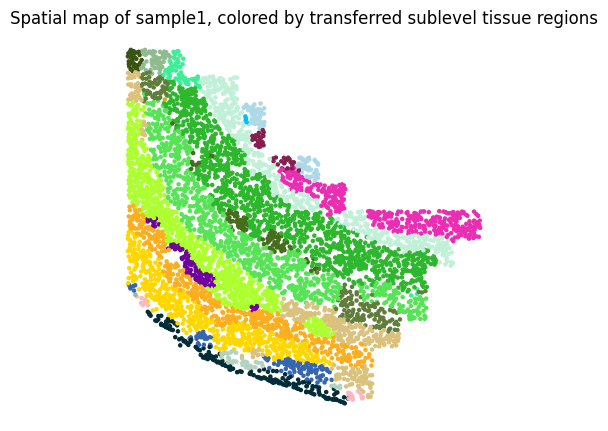

In [16]:
for batch_key in ['sample0','sample1']:
    focus=tissueregion_all_o[tissueregion_all_o.obs['batch']==batch_key]
    coeefi=(max(focus.obs['x'])-min(focus.obs['x']))/(max(focus.obs['y'])-min(focus.obs['y']))

    plt.figure(figsize=(5,5*coeefi))
    plt.scatter(focus.obs['y'],
               focus.obs['x'],
                s=5,
               c=[color_dic[i] for i in focus.obs['transfer_gt_tissue_region_sub']])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.title(f'Spatial map of {batch_key}, colored by transferred sublevel tissue regions')
